# Supervised Learning ELEC 292 Walking or Jumping Classification

## Import Statements

Start by importing necessary libraries.

In [842]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score, f1_score
from sklearn.model_selection import learning_curve

## Define Data Paths

Specify the paths to the CSV files containing data.

In [843]:
csv_paths = ['WalkingIsaiah.csv', 'WalkingMohan.csv', 'WalkingVince.csv', 'JumpingIsaiah.csv', 'JumpingMohan.csv', 'JumpingVince.csv'] 
activity_labels = ['Walking', 'Walking', 'Walking','Jumping', 'Jumping', 'Jumping'] 

## Load Input CSV Data Function

A function to load data from CSV and assign labels.

In [844]:
def load_csv_data(csv_path): # Load data from the files function
    return pd.read_csv(csv_path)

# Load original walking and jumping data
walking_data_isaiah = load_csv_data(csv_paths[0])
jumping_data_isaiah = load_csv_data(csv_paths[3])
walking_data_mohan = load_csv_data(csv_paths[1])
jumping_data_mohan = load_csv_data(csv_paths[4])
walking_data_vince = load_csv_data(csv_paths[2])
jumping_data_vince = load_csv_data(csv_paths[5])

Gain insights into data. 

In [845]:

def check_duplicates_or_nulls(data): # Check for duplicates or null values
    # Check for duplicates
    duplicates = data.duplicated().sum() > 0
    
    # Check for any null values
    nulls = data.isnull().sum().sum() > 0
    
    # Return true if either condition met
    return duplicates or nulls

for data in [walking_data_isaiah, jumping_data_isaiah, walking_data_mohan, jumping_data_mohan, walking_data_vince, jumping_data_vince]:
    if check_duplicates_or_nulls(data):
        print('Duplicates or null values found in data')
    else:
        print('No duplicates or null values found in data')

No duplicates or null values found in data
No duplicates or null values found in data
No duplicates or null values found in data
No duplicates or null values found in data
No duplicates or null values found in data
No duplicates or null values found in data


## Segment Data Into 5-Second Windows

Function segments data into 5-second windows.

In [846]:
def segment_into_windows(data, window_size=5):
    sampling_rate = data['Time (s)'].diff().median() # Sample rate is necessary to determine the number of samples per window, it shows how many data points the accelerometer recorded per second
    samples_per_window = int(window_size / sampling_rate) # Calculate the number of samples per window
    segmented_data = [] # Create an empty list to store the segmented data
    for start in range(0, len(data), samples_per_window): # Iterate over the data with a step size of samples_per_window
        end = start + samples_per_window # Calculate the end index of the window
        if end <= len(data): # Will drop the data that does not fill a window
            segmented_data.append(data.iloc[start:end]) # Append the data to the list
    return segmented_data

## Load, Label and Segment

Load data for each activity, segment and combine into dataset. 

In [847]:
# Load, segment, and label the data
labels = {'Walking': 0, 'Jumping': 1} # Activity labels
segmented_data = []
labels_list = []
for path, activity in zip(csv_paths, activity_labels): # Iterate over the paths and labels
    data = load_csv_data(path) # Load the data
    segments = segment_into_windows(data) # Segment the data (segments holds a list of dataframes)
    segmented_data.extend(segments) # Extend the segmented data list by the segments
    labels_list.extend([labels[activity]] * len(segments)) # Extend the labels list by the labels

## Shuffle and Split data

Split data into training and testing sets (90/10).

In [848]:
# Convert to numpy arrays for shuffling 
X = np.array([segment[['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)']].values for segment in segmented_data]) # Extract the features needed, dropping time and absolute acceleration
y = np.array(labels_list) # Convert the labels list to a numpy array

# Shuffle and split the data into training and testing sets
X, y = shuffle(X, y, random_state=11) # Shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11) # Split data and labels into train and test set (must remain separate for rest of the code)

## Store in HDF5 File

Define path to H5 file.

In [849]:
hdf5_path = 'project_data.hdf5' # Define the path to the hdf5 file  

Store the prepared data into HDF5 file in correct groups and datasets. 

In [850]:
# Open the HDF5 file
with h5py.File(hdf5_path, 'w') as hdf_file: # Must be in write mode to make changes and create groups
    # Create a group for Member1 and add walking and jumping data
    member1_group = hdf_file.create_group('Isaiah')
    member2_group = hdf_file.create_group('Mohan')
    member3_group = hdf_file.create_group('Vince')
    
    # Store the original walking and jumping data
    member1_group.create_dataset('Raw Data', data=pd.concat([walking_data_isaiah, jumping_data_isaiah], ignore_index=True))
    member2_group.create_dataset('Raw Data', data=pd.concat([walking_data_mohan, jumping_data_mohan], ignore_index=True))
    member3_group.create_dataset('Raw Data', data=pd.concat([walking_data_vince, jumping_data_vince], ignore_index=True))
    
    # Create a dataset group
    dataset_group = hdf_file.create_group('dataset')
    
    # Add the training and testing data to the 'dataset' group
    train_group = dataset_group.create_group('Train')
    test_group = dataset_group.create_group('Test')
    
    # Store the training and testing data (the processed segments)
    train_group.create_dataset('y_train', data=y_train)
    test_group.create_dataset('y_test', data=y_test)

## Visualize axis for each dataset

Manipulate data for visualization.

In [851]:
# Define the column names for the acceleration data
x_col, y_col, z_col, time_col= 'Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Time (s)'

# Calculate the average acceleration for each axis for both datasets
walking_averages_isaiah = walking_data_isaiah[[x_col, y_col, z_col]].mean()
jumping_averages_isaiah = jumping_data_isaiah[[x_col, y_col, z_col]].mean()
walking_averages_mohan = walking_data_mohan[[x_col, y_col, z_col]].mean()
jumping_averages_mohan = jumping_data_mohan[[x_col, y_col, z_col]].mean()
walking_averages_vince = walking_data_vince[[x_col, y_col, z_col]].mean()
jumping_averages_vince = jumping_data_vince[[x_col, y_col, z_col]].mean()

# Concatenate the walking and jumping data
walking_dataframes = [walking_data_isaiah, walking_data_mohan, walking_data_vince] 
jumping_dataframes = [jumping_data_isaiah, jumping_data_mohan, jumping_data_vince]

# Function to adjust the time columns (this function was necessary because the time column was not continuous)
def adjust_time(dataframes):
    max_time = 0
    for df in dataframes: # Iterate over the dataframes
        df[time_col] += max_time  # Adjust the time column
        max_time = df[time_col].max()
    return pd.concat(dataframes, ignore_index=True)

# Adjust and concatenate walking and jumping data
combined_walking_data = adjust_time(walking_dataframes)
combined_jumping_data = adjust_time(jumping_dataframes)

# Calculate the average acceleration for each axis for the combined datasets
combined_walking_averages = (walking_averages_isaiah + walking_averages_mohan + walking_averages_vince) / 3
combined_jumping_averages = (jumping_averages_isaiah + jumping_averages_mohan + jumping_averages_vince) / 3

# Define a theme of colors for the plotting
colors = ['dodgerblue', 'steelblue', 'lightblue']

## Difference in Data Plot

Plot the specific differences in data for each individual data set.

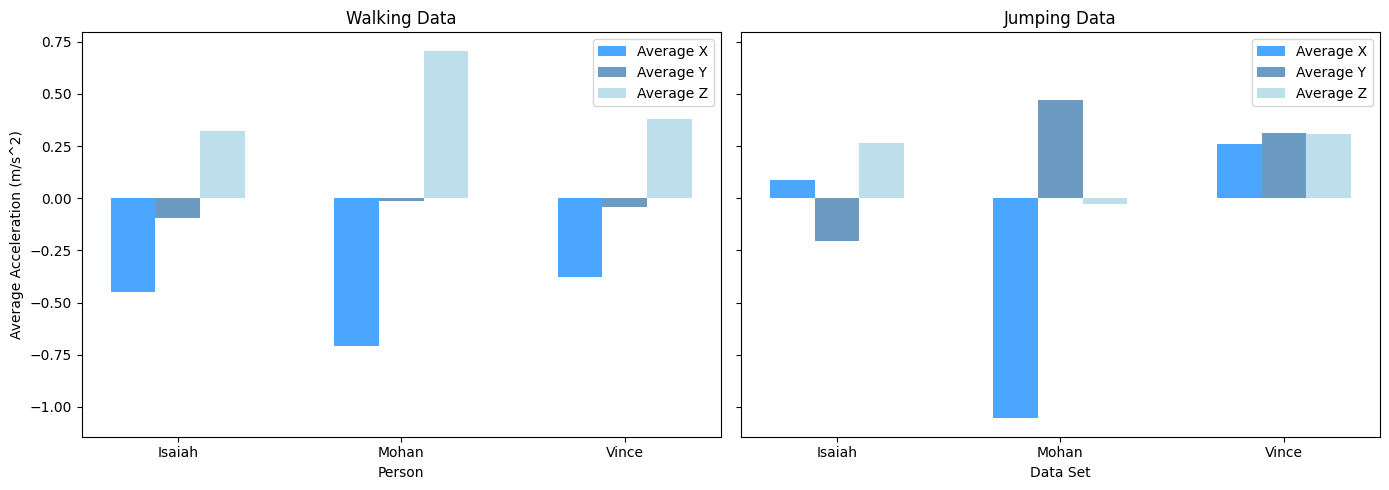

In [852]:
# Settings for the bar chart
names = ['Isaiah', 'Mohan', 'Vince']
n_people = len(names)
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
index = np.arange(n_people)
bar_width = 0.2
opacity = 0.8

# Data for each person and axis
walking_averages = np.array([walking_averages_isaiah.values,walking_averages_mohan.values,walking_averages_vince.values])

jumping_averages = np.array([jumping_averages_isaiah.values,jumping_averages_mohan.values,jumping_averages_vince.values])

# Walking Data Plot
for i, color in enumerate(colors):
    ax[0].bar(index + i*bar_width, walking_averages[:, i], bar_width,
              alpha=opacity, color=color, label=f'Average {["X", "Y", "Z"][i]}')

ax[0].set_xlabel('Person')
ax[0].set_ylabel('Average Acceleration (m/s^2)')
ax[0].set_title('Walking Data')
ax[0].set_xticks(index + bar_width)
ax[0].set_xticklabels(names)
ax[0].legend()

# Jumping Data Plot
for i, color in enumerate(colors):
    ax[1].bar(index + i*bar_width, jumping_averages[:, i], bar_width, # plot the bars
              alpha=opacity, color=color, label=f'Average {["X", "Y", "Z"][i]}') # add labels

ax[1].set_xlabel('Data Set')
ax[1].set_title('Jumping Data')
ax[1].set_xticks(index + bar_width)
ax[1].set_xticklabels(names)
ax[1].legend()

plt.tight_layout()
plt.show()

## Metadata visualization graph

Plot the meta data information including the time spent recording walking and jumping.

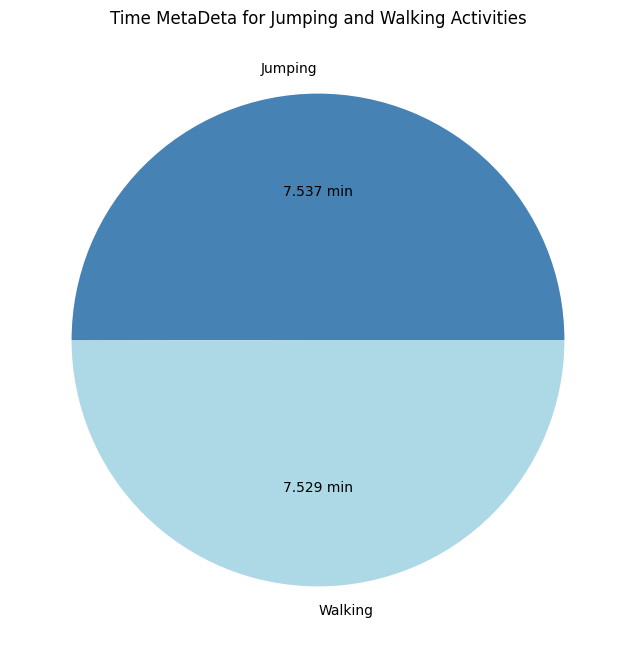

In [853]:
# Load the data from CSV files
jump_df_isaiah = pd.read_csv('jumpMetaIsaiah.csv')
walk_df_isaiah = pd.read_csv('walkMetaIsaiah.csv')
jump_df_mohan = pd.read_csv('jumpMetaMohan.csv')
walk_df_mohan = pd.read_csv('walkMetaMohan.csv')
jump_df_vince = pd.read_csv('jumpMetaVince.csv')
walk_df_vince = pd.read_csv('walkMetaVince.csv')

# Calculate the duration of the activities
jump_duration_isaiah = jump_df_isaiah[jump_df_isaiah['event'] == 'PAUSE']['experiment time'].iloc[0]
walk_duration_isaiah = walk_df_isaiah[walk_df_isaiah['event'] == 'PAUSE']['experiment time'].iloc[0]
jump_duration_mohan = jump_df_mohan[jump_df_mohan['event'] == 'PAUSE']['experiment time'].iloc[0]
walk_duration_mohan = walk_df_mohan[walk_df_mohan['event'] == 'PAUSE']['experiment time'].iloc[0]
jump_duration_vince = jump_df_vince[jump_df_vince['event'] == 'PAUSE']['experiment time'].iloc[0]
walk_duration_vince = walk_df_vince[walk_df_vince['event'] == 'PAUSE']['experiment time'].iloc[0]

# Convert seconds to minutes
jump_duration_minutes_isaiah = jump_duration_isaiah / 60
walk_duration_minutes_isaiah = walk_duration_isaiah / 60
jump_duration_minutes_mohan = jump_duration_isaiah / 60
walk_duration_minutes_mohan = walk_duration_isaiah / 60
jump_duration_minutes_vince = jump_duration_isaiah / 60
walk_duration_minutes_vince = walk_duration_isaiah / 60

# Create a pie chart with the actual durations in minutes
activity_durations = [jump_duration_minutes_isaiah + jump_duration_minutes_mohan + jump_duration_minutes_vince, walk_duration_minutes_isaiah + walk_duration_minutes_mohan + walk_duration_minutes_vince]
activity_labels = ['Jumping', 'Walking']

plt.figure(figsize=(8, 8))
plt.pie(activity_durations, labels=activity_labels, colors=colors[1:3], autopct=lambda p: '{:.03f} min'.format(p * sum(activity_durations) / 100)) # Plot the pie chart
plt.title('Time MetaDeta for Jumping and Walking Activities')
plt.show()

## Plot acceleration vs time for combined data

Plot the combined data to show the changing acceleration vs time for walking.

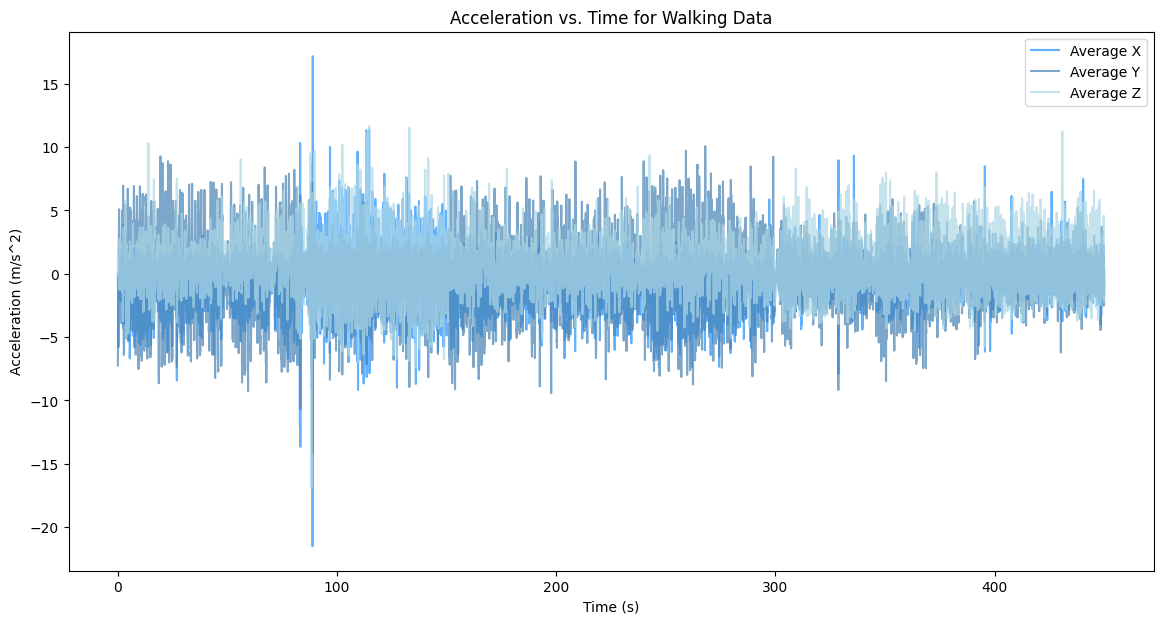

In [854]:
# Plotting x, y, z accelerations vs. time with distinct colors for each line
plt.figure(figsize=(14, 7))

# Plot each acceleration component against time with specified colors
plt.plot(combined_walking_data[time_col], combined_walking_data[x_col], label='Average X', color=colors[0], alpha=0.7)
plt.plot(combined_walking_data[time_col], combined_walking_data[y_col], label='Average Y', color=colors[1], alpha=0.7)
plt.plot(combined_walking_data[time_col], combined_walking_data[z_col], label='Average Z', color=colors[2], alpha=0.7)

# Add title and labels
plt.title('Acceleration vs. Time for Walking Data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

# Display legend and plot
plt.legend()
plt.show()

Plot the combined data to show the changing acceleration vs time for jumping.

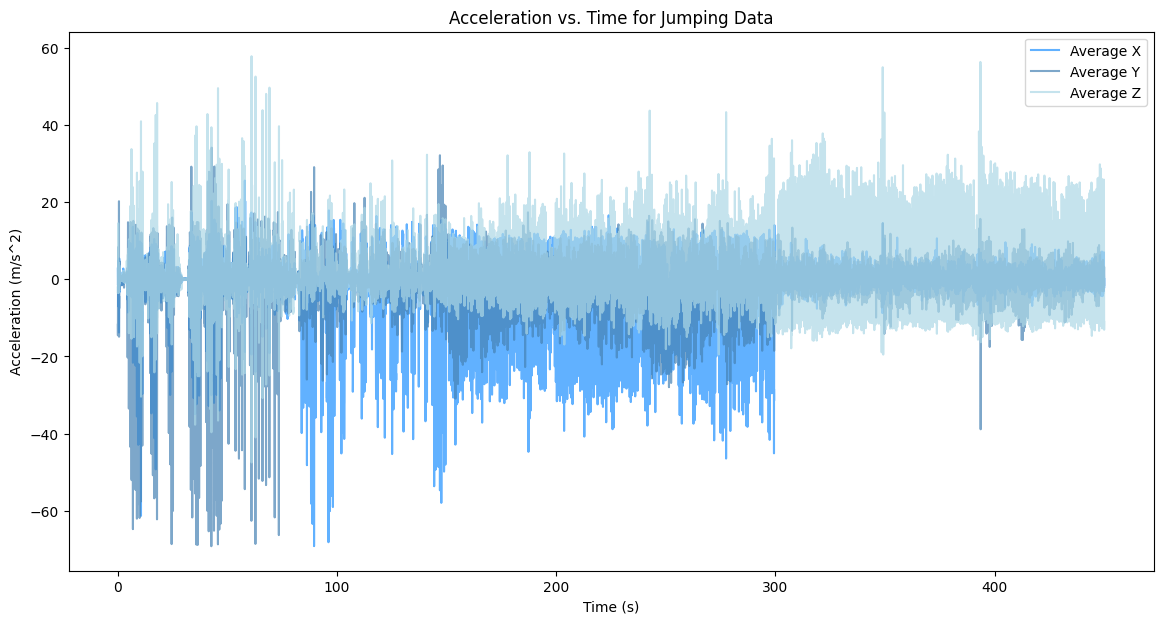

In [855]:
# Plotting x, y, z accelerations vs. time with distinct colors for each line
plt.figure(figsize=(14, 7))

# Plot each acceleration component against time with specified colors
plt.plot(combined_jumping_data[time_col], combined_jumping_data[x_col], label='Average X', color=colors[0], alpha=0.7)
plt.plot(combined_jumping_data[time_col], combined_jumping_data[y_col], label='Average Y', color=colors[1], alpha=0.7)
plt.plot(combined_jumping_data[time_col], combined_jumping_data[z_col], label='Average Z', color=colors[2], alpha=0.7)

# Add title and labels
plt.title('Acceleration vs. Time for Jumping Data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

# Display legend
plt.legend()

# Show the plot
plt.show()

## Plot histograms of acceleration for walking and jumping

Plotted the histograms assosciated with acceleration for both jumping and walking displaying patterns for each axis. 

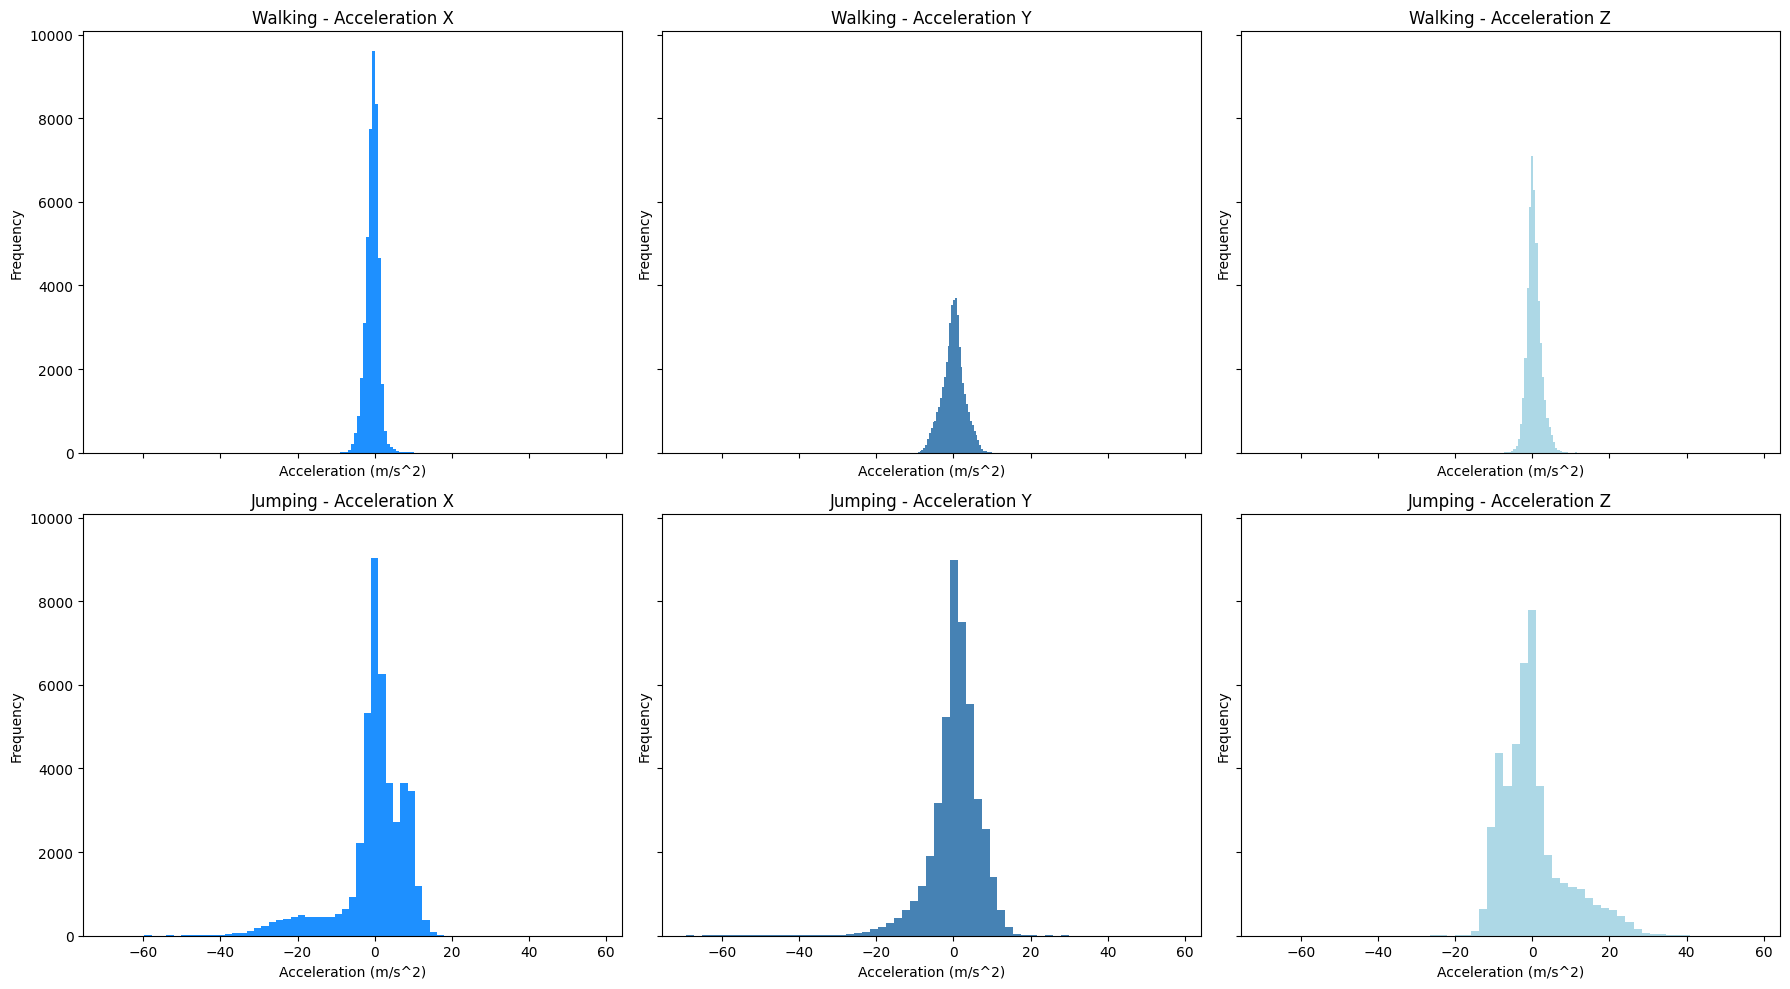

In [856]:
# Plotting histograms of acceleration values for both activities
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Set common parameters for the histograms
bins = 50 # Number of buckets data is divided into

# Reference: https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/

# Walking data histograms
axes[0, 0].hist(combined_walking_data[x_col], bins=bins, color='dodgerblue')
axes[0, 0].set_title('Walking - Acceleration X')
axes[0, 1].hist(combined_walking_data[y_col], bins=bins, color='steelblue')
axes[0, 1].set_title('Walking - Acceleration Y')
axes[0, 2].hist(combined_walking_data[z_col], bins=bins, color='lightblue')
axes[0, 2].set_title('Walking - Acceleration Z')

# Jumping data histograms
axes[1, 0].hist(combined_jumping_data[x_col], bins=bins, color='dodgerblue')
axes[1, 0].set_title('Jumping - Acceleration X')
axes[1, 1].hist(combined_jumping_data[y_col], bins=bins, color='steelblue')
axes[1, 1].set_title('Jumping - Acceleration Y')
axes[1, 2].hist(combined_jumping_data[z_col], bins=bins, color='lightblue')
axes[1, 2].set_title('Jumping - Acceleration Z')

# Set labels for the axes
for ax in axes.flat:
    ax.set(xlabel='Acceleration (m/s^2)', ylabel='Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Begin preprocessing

Apply the low pass filter through use of a moving average with a window size of 5.

In [857]:
def moving_average_filter(data, window_size=5): #  Define the moving average filter
    filtered_data = np.zeros_like(data) # Create an array to store the filtered data (default is zeros)
    for segment in range(data.shape[0]):
        for feature in range(data.shape[2]):
            df = pd.DataFrame(data[segment, :, feature])  # Convert the time series for the current segment and feature into a DataFrame
            rolling_mean = df.rolling(window_size, center=True, min_periods=1).mean() # Apply rolling mean
            filtered_data[segment, :, feature] = rolling_mean.to_numpy().flatten() # Store the results back into the filtered_data array
    return filtered_data

# Assuming X_train and X_test are your data
X_train_filtered = moving_average_filter(X_train, window_size=5)
X_test_filtered = moving_average_filter(X_test, window_size=5)

(162, 497, 3) (18, 497, 3)


## Visualize the result of the moving average filter

Showing an example of a singular segment to demonstrate the effects of the moving average filter. 

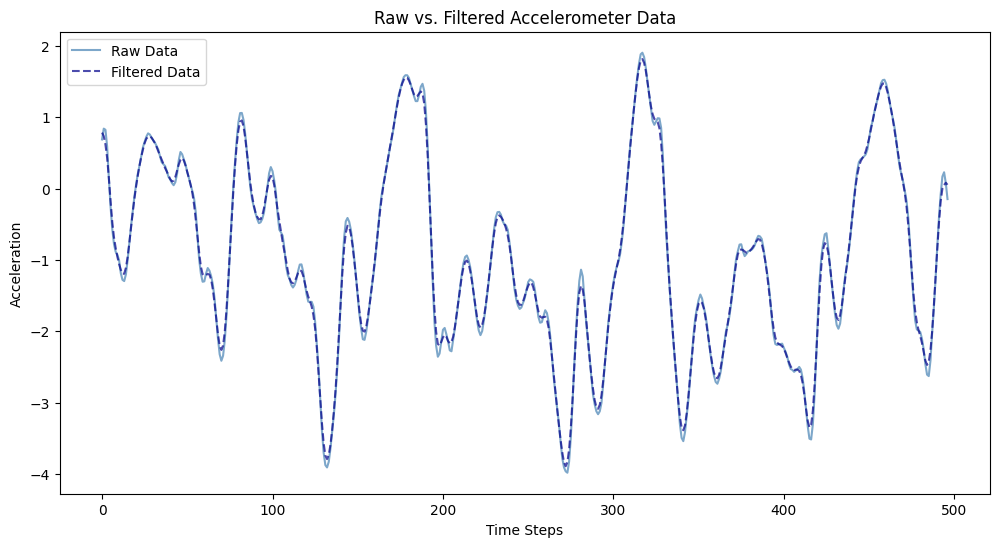

In [858]:

# Select the segment and feature to visualize
segment_index = 0 # first segment
feature_index = 0 # 0: X

# Raw data for the selected segment and feature
raw_data_segment = X_train[segment_index, :, feature_index]

# Filtered data for the selected segment and feature
filtered_data_segment = X_train_filtered[segment_index, :, feature_index]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(raw_data_segment, label='Raw Data', linestyle='-', alpha=0.7, color='steelblue')
plt.plot(filtered_data_segment, label='Filtered Data', linestyle='--', alpha=0.7, color='darkblue')
plt.title(f'Raw vs. Filtered Accelerometer Data')
plt.xlabel('Time Steps')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

## Create function for feature extraction

Function for feature extraction focuses on 10 core data metrics, applying these across all 3 axis to completely capture patterns. 

In [859]:
# Define the function to extract time-domain features from a segment
def extract_features_from_segment(segment_data):
    features = []
    
    # Reference: https://medium.com/@rehanmbl/extracting-time-domain-and-frequency-domain-features-from-a-signal-python-implementation-1-2-d36148c949ba
    
    for axis_data in segment_data.T:  # Transpose to iterate over axes
        # Time-domain features
        axis_features = {
            'mean': np.mean(axis_data),
            'std_dev': np.std(axis_data),
            'max': np.max(axis_data),
            'min': np.min(axis_data),
            'median': np.median(axis_data),
            'range': np.max(axis_data) - np.min(axis_data),
            'iqr': np.percentile(axis_data, 75) - np.percentile(axis_data, 25),
            'variance': np.var(axis_data),
            'skewness': skew(axis_data),
            'kurtosis': kurtosis(axis_data),
        }
        features.append(axis_features)
    
    # Flatten the list of dictionaries into a single dictionary
    flattened_features = {}
    for i, axis_feature in enumerate(features):
        for key, value in axis_feature.items():
            flattened_features[f'axis_{i}_{key}'] = value
    
    return flattened_features

Feature extraction function is applied to the filtered data. 

In [860]:
# Initialize lists to hold the features for all segments
train_features_list = []
test_features_list = []

for i in range(X_train_filtered.shape[0]): # Extract features from each segment
    segment_features = extract_features_from_segment(X_train_filtered[i])
    train_features_list.append(segment_features) 

   
for i in range(X_test_filtered.shape[0]):
    segment_features = extract_features_from_segment(X_test_filtered[i])
    test_features_list.append(segment_features)

# Convert the list of features to pandas DataFrames
train_features_df = pd.DataFrame(train_features_list)
test_features_df = pd.DataFrame(test_features_list)

## Z Score normalization is done to the extracted features 

Using StandardScaler to properly normalize the individual features for the train and test set, converting back to data frames upon completion. 

In [861]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training features and transform both training and test features
train_features_scaled = scaler.fit_transform(train_features_df)
test_features_scaled = scaler.transform(test_features_df)

joblib.dump(scaler, 'scaler.joblib')

# Convert the scaled features back to Pandas DataFrames
train_features_scaled_df = pd.DataFrame(train_features_scaled, columns=train_features_df.columns)
test_features_scaled_df = pd.DataFrame(test_features_scaled, columns=test_features_df.columns)

## Add train and test data to hdf5

Now that alterations to the train and test are complete, they can be added to the hdf5 file in under their respective groups. 

In [862]:
# Open the HDF5 file in read/write mode
with h5py.File(hdf5_path, 'r+') as hdf_file:
    # Create new datasets from the DataFrames
    hdf_file.create_dataset('dataset/Train/X_train', data=train_features_scaled_df.to_numpy())
    hdf_file.create_dataset('dataset/Test/X_test', data=test_features_scaled_df.to_numpy())

## Run Logistic Regression model

Model is intialized, trained and test with accuracy scores displayed. 

In [863]:

# Initialize the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=11)

# Train the logistic regression model
logistic_model.fit(train_features_scaled_df, y_train)

# Predict the classes for the test set
y_pred = logistic_model.predict(test_features_scaled_df) # Predict the classes
y_pred_proba = logistic_model.predict_proba(test_features_scaled_df) # Predict the probabilities

# Save the model to export for the application
joblib.dump(logistic_model, 'logistic_model.joblib')

['logistic_model.joblib']

## Accuracy Testing

Check the model tn ensure it is doing well in terms of classifications.

Accuracy on the test set: 1.00000


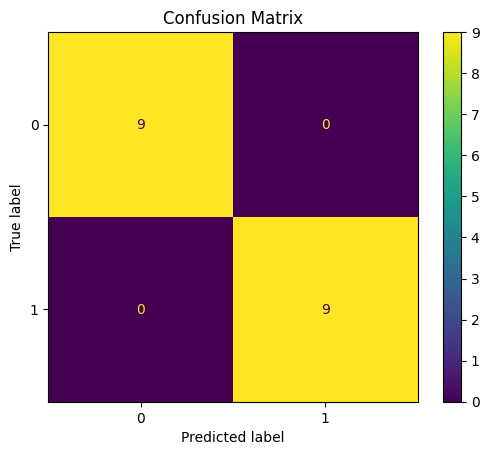

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The F1 score is:  1.0


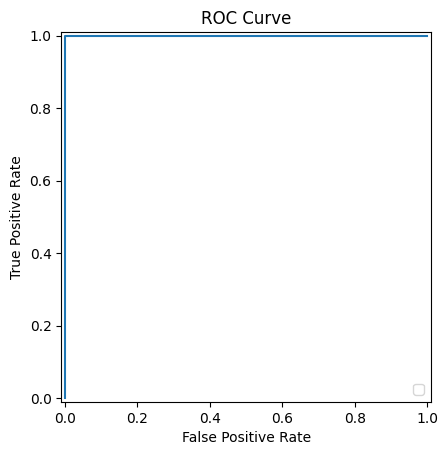

The AUC is:  1.0


In [864]:
# Calculate and print the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.5f}")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
cm_display = ConfusionMatrixDisplay(cm).plot()
# Set title for the confusion matrix plot
plt.title('Confusion Matrix')
# Show confusion matrix plot
plt.show()

# Calculate and print the F1 score
f1 = f1_score(y_test, y_pred)
print('The F1 score is: ', f1)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1], pos_label=logistic_model.classes_[1])
# Display ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
# Set title for the ROc  curve plot
plt.title('ROC Curve')
# Show ROC curve plot
plt.show()

# Calculate and print the AUC
auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print('The AUC is: ', auc)

## Cross-validation 

To ensure that the model is functioning well, cross-validation is done with an average result shown. 

/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/linear_

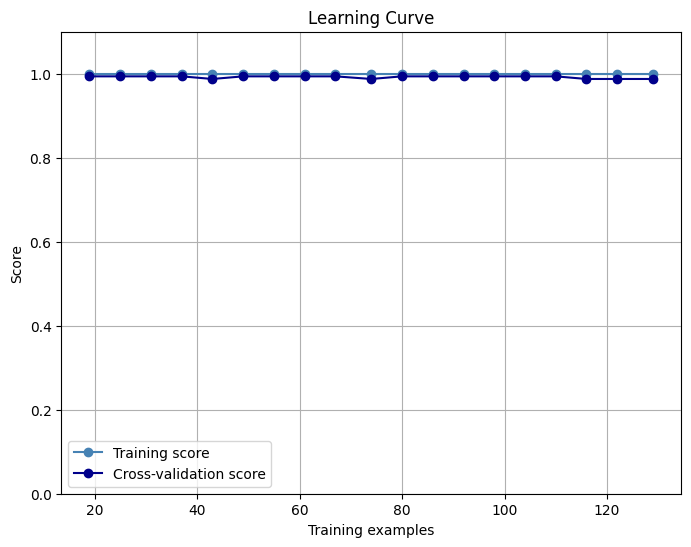

In [865]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    logistic_model,  # Your model
    train_features_scaled_df,         # Feature matrix
    y_train,         # Target vector
    cv=5,            # Cross-validation splitting strategy
    n_jobs=-1,       # Use all CPU cores
    train_sizes=np.linspace(0.1, 1.0, 20)  # Use 20 evenly spaced relative intervals for training set sizes
)

# Calculate means and standard deviations for the training and test sets
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")


plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="darkblue", label="Cross-validation score")

plt.ylim(0.0, 1.1)  # Adjust y-axis to go from 0 to 100% for clarity
plt.legend(loc="best")
plt.grid()
plt.show()